In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from PIL import Image
import warnings
import itertools
from mlxtend.frequent_patterns import apriori, association_rules

np.random.seed(42)

In [19]:
fashion_df = pd.read_csv("../data/cleaned_data/fashion_dataset.csv")

In [20]:
def load_attributes_cloth(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    num_attributes = int(lines[0].strip())
    columns = lines[1].strip().split()
    
    data = []
    for i in range(2, len(lines)):
        line = lines[i].strip()
        parts = line.split()
        
        attr_type = int(parts[-1])
        attr_name = ' '.join(parts[:-1])
        
        attr_id = i - 2
        
        data.append([attr_id, attr_name, attr_type])
    
    attr_df = pd.DataFrame(data, columns=['attr_id', 'attr_name', 'attr_type'])
    attr_df['attr_type_name'] = attr_df['attr_type'].map({
        1: 'texture', 
        2: 'fabric', 
        3: 'shape', 
        4: 'part', 
        5: 'style'
    })
    
    return attr_df
attr_df = load_attributes_cloth("../data/Anno_coarse/list_attr_cloth.txt")


In [21]:
# Extract all attributes as a list
all_attributes = []
for attrs in fashion_df['positive_attributes']:
    all_attributes.extend(attrs)
print(len(all_attributes))

attr_count = Counter(all_attributes)
print(attr_count)

# DF with attribute counts
attr_count_df = pd.DataFrame({
    'attr_id': list(attr_count.keys()),
    'count': list(attr_count.values())
})

attr_count_df['attr_id'] = attr_count_df['attr_id'].astype(str)
attr_df['attr_id'] = attr_df['attr_id'].astype(str)

4749219
Counter({',': 684738, ' ': 684738, '3': 354968, '8': 340360, '1': 299875, '2': 289528, '[': 289212, ']': 289212, '6': 284199, '5': 283679, '7': 267500, '9': 250359, '4': 236285, '0': 194566})


In [22]:
# Merge with attribute names if available
attr_count_df = pd.merge(attr_count_df, 
                           attr_df[['attr_id', 'attr_name', 'attr_type_name']], 
                           on='attr_id', how='left')

# calculate percentage and sort by count
attr_count_df['percentage'] = attr_count_df['count'] / len(fashion_df) * 100
attr_count_df = attr_count_df.sort_values('count', ascending=False)

In [24]:
def gen_fashion_baskets(fashion_df, attr_df, num_baskets=2000, items_per_basket=4):
    """Generate baskets from fashion items and attributes"""
    def get_item_name(row, attr_df):
        category = row['category_name']
        attrs = row['positive_attributes']
        if attr_df is not None and len(attrs) > 0:
            # Get just the most important attribute
            attr_id = attrs[0]
            attr_row = attr_df[attr_df['attr_id'] == attr_id]
            if not attr_row.empty:
                attr_type = attr_row['attr_type_name'].iloc[0]
                # Only include texture or fabric attributes to generalize better
                if attr_type in ['texture', 'fabric']:
                    return f"{category} ({attr_row['attr_name'].iloc[0]})"
        return category

    # mapping from image_id to item name
    item_names = {}
    for idx, row in fashion_df.iterrows():
        item_names[idx] = get_item_name(row, attr_df)

    # baskets based on clothing types
    baskets = []

    # group by clothin type
    upper_body = fashion_df[fashion_df['category_type_name'] == 'upper-body'].index.tolist()
    lower_body = fashion_df[fashion_df['category_type_name'] == 'lower-body'].index.tolist()
    full_body = fashion_df[fashion_df['category_type_name'] == 'full-body'].index.tolist()

    # Ensure we have items of each type
    if not upper_body:
        upper_body = fashion_df.sample(min(100, len(df))).index.tolist()
    if not lower_body:
        lower_body = fashion_df.sample(min(100, len(df))).index.tolist()
    if not full_body:
        full_body = fashion_df.sample(min(100, len(df))).index.tolist()

    for _ in range(num_baskets):
        basket = []

        # random basket composition
        basket_type = np.random.choice(['upper+lower', 'full', 'upper', 'lower', 'mixed'], 
                                       p=[0.5, 0.2, 0.1, 0.1, 0.1])

        if basket_type == 'upper+lower':
            # Upper body + lower body outfit
            if upper_body and lower_body:
                basket.append(random.choice(upper_body))
                basket.append(random.choice(lower_body))
                
                # potentially add another item
                if random.random() < 0.3 and upper_body:
                    basket.append(random.choice(upper_body))
                    
        elif basket_type == 'full':
            # Full body outfit
            if full_body:
                basket.append(random.choice(full_body))
                
                # Maybe add an upper body item
                if random.random() < 0.7 and upper_body:
                    basket.append(random.choice(upper_body))
                    
        elif basket_type == 'upper':
            # Multiple upper body items
            if upper_body:
                # Add 1-3 upper body items
                for _ in range(random.randint(1, 3)):
                    if upper_body:
                        basket.append(random.choice(upper_body))
                    
        elif basket_type == 'lower':
            # Multiple lower body items
            if lower_body:
                # Add 1-2 lower body items
                for _ in range(random.randint(1, 2)):
                    if lower_body:
                        basket.append(random.choice(lower_body))
                    
        else:  # 'mixed'
            # Random mix of items
            all_items = fashion_df.index.tolist()
            # Add 2-4 random items
            for _ in range(random.randint(2, 4)):
                if all_items:
                    basket.append(random.choice(all_items))

        basket = list(set(basket))
        if basket:
            baskets.append(basket)

    labeled_baskets = []
    for basket in baskets:
        labeled_basket = [item_names[item_idx] for item_idx in basket]
        labeled_baskets.append(labeled_basket)
        
    print(f"{len(labeled_baskets)} baskets created, average of {np.mean([len(b) for b in labeled_baskets]):.1f} items per basket")
    # reverse mapping from item names to IDs
    item_mapping = {v: k for k, v in item_names.items()}
    
    return labeled_baskets, item_mapping

Created 2000 baskets with an average of 2.1 items per basket

Example baskets:
Basket 1: ['Top', 'Leggings']
Basket 2: ['Leggings', 'Jacket', 'Dress', 'Dress']
Basket 3: ['Hoodie', 'Top']
Basket 4: ['Dress', 'Cardigan']
Basket 5: ['Top', 'Shorts']


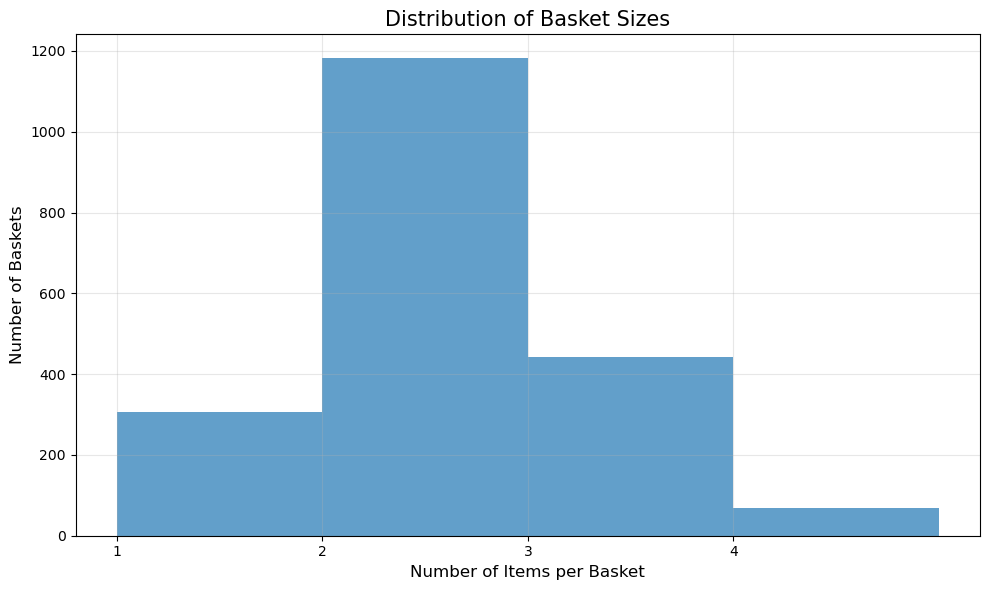

In [25]:
baskets, item_mapping = gen_fashion_baskets(fashion_df, attr_df)

print("\nExample baskets:")
for i, basket in enumerate(baskets[:5]):
    print(f"Basket {i+1}: {basket}")

In [27]:
def group_items_by_category_type(df):
    """Group items by their category type to create higher-level categories"""
    category_type_groups = {}
    
    for idx, row in df.iterrows():
        cat_type = row['category_type_name']
        cat_name = row['category_name']
        
        if cat_type not in category_type_groups:
            category_type_groups[cat_type] = set()
        
        category_type_groups[cat_type].add(cat_name)
    
    # Reverse mapping
    category_to_group = {}
    for group, categories in category_type_groups.items():
        for category in categories:
            category_to_group[category] = group
    
    return category_to_group

category_to_group = group_items_by_category_type(fashion_df)

def add_group_baskets(baskets, category_to_group):
    """Add baskets based on broader category groups"""
    grouped_baskets = []
    
    for basket in baskets:
        # Keep original basket
        grouped_baskets.append(basket)
        
        # Grouped version of the basket
        grouped_items = [category_to_group.get(item.split(' (')[0], item) for item in basket]
        grouped_items = list(set(grouped_items))  # Remove duplicates
        if len(grouped_items) > 1:  # Ensure we have at least 2 items
            grouped_baskets.append(grouped_items)
    
    return grouped_baskets

enhanced_baskets = add_group_baskets(baskets, category_to_group)

In [28]:
def add_style_rule_baskets(baskets, df, n_additional=500):
    """Add baskets based on basic fashion styling rules"""
    style_rules = [
        # Format: (upper category, lower category, probability)
        ('T-shirt', 'Jeans', 0.3),
        ('Blouse', 'Skirt', 0.2),
        ('Sweater', 'Leggings', 0.15),
        ('Button-down', 'Chinos', 0.15),
        ('Jacket', 'Jeans', 0.2),
        # can add more fashion pairings
    ]
    
    category_to_items = {}
    for idx, row in df.iterrows():
        cat = row['category_name']
        if cat not in category_to_items:
            category_to_items[cat] = []
        category_to_items[cat].append(idx)
    
    # Create additional baskets based on style rules
    additional_baskets = []
    for _ in range(n_additional):
        rule = random.choice(style_rules)
        
        # Skip if we don't have examples of these categories
        if rule[0] not in category_to_items or rule[1] not in category_to_items:
            continue
        
        # Create a basket based on the style rule
        upper_items = category_to_items[rule[0]]
        lower_items = category_to_items[rule[1]]
        
        if upper_items and lower_items:
            basket = [random.choice(upper_items), random.choice(lower_items)]
            # Sometimes add an accessory
            if random.random() < 0.4 and 'Accessories' in category_to_items:
                basket.append(random.choice(category_to_items['Accessories']))
            
            additional_baskets.append(basket)
    
    return baskets + additional_baskets

In [29]:
def encode_baskets(baskets, min_support=0.01):
    """
    Encode baskets into a binary matrix format for association rule mining
    """    
    # Get all unique items
    all_items = set()
    for basket in baskets:
        all_items.update(basket)
    
    print(f"{len(all_items)} unique items across all baskets")
    
    matrix = []
    for basket in baskets:
        row = {item: 1 if item in basket else 0 for item in all_items}
        matrix.append(row)
    
    encoded_df = pd.DataFrame(matrix)
    
    # Filter out items that appear too infrequently
    min_count = int(min_support * len(baskets))
    item_counts = encoded_df.sum()
    frequent_items = item_counts[item_counts >= min_count].index.tolist()
        
    encoded_df = encoded_df[frequent_items]
    
    return encoded_df

In [47]:
#encoded_df = encode_baskets(enhanced_baskets, min_support=0.01)
encoded_df = encode_baskets(add_style_rule_baskets(enhanced_baskets, fashion_df), min_support=0.01)
print(f"Encoded matrix shape: {encoded_df.shape}")
display(encoded_df.iloc[:5, :5])

46 unique items across all baskets
Keeping 22 items that appear in at least 34 baskets (1.0% of total)
Encoded matrix shape: (3433, 22)


,Jacket,Jumpsuit,Top,Romper,Hoodie
0,0,0,1,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,1


In [48]:
def find_frequent_itemsets(encoded_df, min_support=0.005):
    """
    Apriori algorithm to find frequent itemsets
    """    
    frequent_itemsets = apriori(encoded_df, 
                              min_support=min_support, 
                              use_colnames=True, 
                              max_len=5,  
                              low_memory=True, 
                              verbose=1)
    
    # Sort by support
    frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
    
    print(f"Found {len(frequent_itemsets)} frequent itemsets")
    
    return frequent_itemsets

In [49]:
# Find frequent itemsets
frequent_itemsets = find_frequent_itemsets(encoded_df, min_support=0.005)

# Display the top frequent itemsets
print("\nTop 10 frequent itemsets by support:")
display(frequent_itemsets.head(10))

Processing 4 combinations | Sampling itemset size 3 2
Found 68 frequent itemsets

Top 10 frequent itemsets by support:


/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
10,0.412759,(upper-body)
7,0.315759,(lower-body)
37,0.311098,"(upper-body, lower-body)"
8,0.157879,(Tee)
21,0.135450,(Shorts)
11,0.122925,(Dress)
17,0.118846,(full-body)
54,0.114186,"(upper-body, full-body)"
16,0.112729,(Blouse)
13,0.102826,(Skirt)


In [50]:
# Create a new column with itemset size
frequent_itemsets['itemset_size'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [53]:
def generate_association_rules(frequent_itemsets, min_confidence=0.5, min_lift=1.0):
    """
    Generate association rules from frequent itemsets
    """    
    rules = association_rules(frequent_itemsets, 
                             metric="confidence", 
                             min_threshold=min_confidence)
    
    # Filter by lift
    rules = rules[rules['lift'] >= min_lift]
    
    # Sort by confidence then lift
    rules = rules.sort_values(['confidence', 'lift'], ascending=False)
    
    print(f"]{len(rules)} association rules found")
    
    return rules

In [54]:
rules = generate_association_rules(frequent_itemsets, min_confidence=0.5, min_lift=1.0)

print("\nTop 10 association rules by confidence:")
display(rules.head(10))

Generating association rules with minimum confidence of 0.5 and minimum lift of 1.0...
Found 4 association rules

Top 10 association rules by confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,(lower-body),(upper-body),0.315759,0.412759,0.311098,0.985240,2.386964,1.0,0.180766,39.785610,0.849200,0.745290,0.974865,0.869472
2,(full-body),(upper-body),0.118846,0.412759,0.114186,0.960784,2.327715,1.0,0.065131,14.974658,0.647327,0.273552,0.933221,0.618713
0,(upper-body),(lower-body),0.412759,0.315759,0.311098,0.753705,2.386964,1.0,0.180766,2.778137,0.989470,0.745290,0.640047,0.869472
3,"(full-body, lower-body)",(upper-body),0.017186,0.412759,0.012525,0.728814,1.765714,1.0,0.005432,2.165453,0.441240,0.030007,0.538203,0.379580
